# Глава 8 (Сазанович Владислав М3339)

In [559]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy
import scipy.stats
import hashlib
import time
import copy

from numpy.linalg import matrix_rank
from tqdm import tqdm

from graphviz import Digraph
from IPython.display import display

import scipy.integrate as integrate

In [560]:
# generate all sequences of length l
def generate(l):
    res = []
    
    for i in range(0, 2**l):
        b = bin(i)[2:]
        b = '0' * (l - len(b)) + b
        b = np.array(list(map(lambda x: int(x), b)))
        res.append(b)
        
    return np.array(res)

# Задание 6

In [561]:
# Преобразует массив в строку [1,0,0] -> 100
def np_to_str(arr):
    return ''.join(map(lambda x : str(x), arr))

In [562]:
# Преобразует массив в число [1,0,0] -> 8
def np_to_num(arr):
    return int(np_to_str(arr), 2)

In [563]:
# Преобразует вектор в D^{cумма элементов}
def convert_to_D(arr):
    pow = np.sum(arr)
    if pow == 0:
        return '1'
    elif pow == 1:
        return 'D'
    else:
        return 'D^{}'.format(pow)

In [564]:
# Для заданного состояния считает переходы
def get_transitions(state, g):
    zero = np.append([0], state)
    one = np.append([1], state)
    
    # нужно перевернуть полиномы так как в numpy они представляются в другом порядке
    g1_r = []
    for i in range(len(g)):
        g1_r.append(g[i][::-1])
    
    zero_code = [np.sum(x * zero) % 2 for x in g]
    one_code = [np.sum(x * one) % 2 for x in g]
    
    return zero[:len(state)], zero_code, one[:len(state)], one_code

In [565]:
# Пример из учебника
g1 = [1, 0, 1] # 1 + D^2
g2 = [1, 1, 1] # 1 + D + D^2
get_transitions([0, 0], [g1, g2])

(array([0, 0]), [0, 0], array([1, 0]), [1, 1])

In [566]:
# Выводит граф для заданной длины состояний и порождающих полиномов
def create_graph(power, g, d_labels=False, circo=False):
    dot = Digraph(comment='Automata for coder')
    for node in generate(power):
        label = np_to_str(node)
        if d_labels:
            label = str(int(label, 2)) # convert to number
        dot.node(np_to_str(node), label)
        
    for node in generate(power):
        z_state, z_code, o_state, o_code = get_transitions(node, g)
        
        z_label = np_to_str(z_code) + ' (0)'
        o_label = np_to_str(o_code) + ' (1)'
        
        if d_labels:
            z_label = convert_to_D(z_code)
            o_label = convert_to_D(o_code)
        
        dot.edge(np_to_str(node), np_to_str(z_state), label=z_label)
        dot.edge(np_to_str(node), np_to_str(o_state), label=o_label)
       
    if circo:
        dot.body = ['layout="circo"', *dot.body]
    return dot

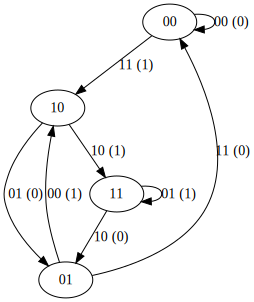

In [567]:
# Пример из учебника
create_graph(2, [g1, g2])

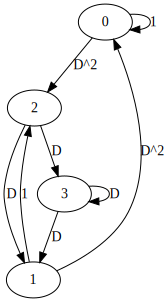

In [568]:
create_graph(2, [g1, g2], d_labels=True)

In [569]:
def to_D_for_sys(pow):
    if pow == 0:
        return ''
    elif pow == 1:
        return 'D'
    else:
        return 'D^{}'.format(pow)

# Напишем систему уравнений для вычисления g0(D) для этого посчитаем переходы
def get_system(power, g, with_I=False, pr=False):
    eq_sys = []
    for i in range(2**power):
        eq_sys.append([])
        
    for node in generate(power):
        num = np_to_num(node)
        
        z_state, z_code, o_state, o_code = get_transitions(node, g)
        z_state = np_to_num(z_state)
        z_code = np.sum(z_code)
        o_state = np_to_num(o_state)
        o_code = np.sum(o_code)
        
        if num != 0:
            eq_sys[z_state].append((num, z_code, 0))
        eq_sys[o_state].append((num, o_code, 1))
        
        
    if pr:
        for i in range(len(eq_sys)):
            ans = 'g{}(D) = '.format(i)
            
            for s in eq_sys[i]:
                I = ''
                aI = ''
                if with_I:
                    I = 'I'
                    aI = ', I'
                if s[2] == 0:
                    I = ''
                    
                if (s[0] == 0):
                    ans = ans + '{}{} + '.format(to_D_for_sys(s[1]), I)
                else:
                    ans = ans + '{}{}g{}(D{}) + '.format(to_D_for_sys(s[1]), I, s[0], aI)
            print(ans[:-3])
    return eq_sys

In [570]:
# Пример из учебника
sys = get_system(2, [g1, g2], True, True)

g0(D) = D^2g1(D, I)
g1(D) = Dg2(D, I) + Dg3(D, I)
g2(D) = D^2I + Ig1(D, I)
g3(D) = DIg2(D, I) + DIg3(D, I)


# Данные из задания

In [571]:
# 4 7 3
g1 = np.array([0, 0, 1]) # 1 (4)
g2 = np.array([1, 1, 1]) # 1 + D + D^2 (7)
g3 = np.array([1, 1, 0]) # D + D^2 (3)

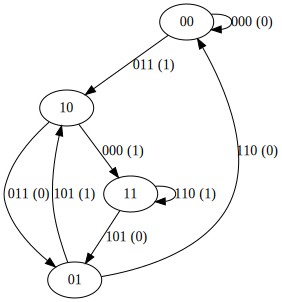

In [572]:
create_graph(2, [g1, g2, g3])

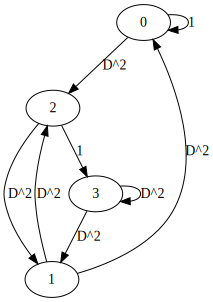

In [573]:
create_graph(2, [g1, g2, g3], d_labels=True)

Теперь решим систему:

In [574]:
sys = get_system(2, [g1, g2, g3], True, True)

g0(D) = D^2g1(D, I)
g1(D) = D^2g2(D, I) + D^2g3(D, I)
g2(D) = D^2I + D^2Ig1(D, I)
g3(D) = Ig2(D, I) + D^2Ig3(D, I)


In [575]:
# g1 = (I * D^4 * (1 + I - I*D^2)) / (1 - I*D^2 - I*D^4 - I^2*D^4 + I^2*D^6)
# g0 = (I * D^6 * (1 + I - I*D^2)) / (1 - (I*D^2 + I*D^4 + I^2*D^4 - I^2*D^6))

Производящая функция равна:

$T(D, I) = (ID^6(1 + I - ID^2))\ (1 + (ID^2 + ID^4 + I^2D^4 - I^2D^6) + (ID^2 + ID^4 + I^2D^4 - I^2D^6)^2 +\ ... )$

$T(D, I) =\ ... \ + D^{20} (-I^6) + 3 D^{18} I^6 + 3 D^{18} I^5 - 3 D^{16} I^6 - 4 D^{16} I^5 - 3 D^{16} I^4 + D^{14} I^6 - D^{14} I^5 + D^{14} I^3 + 2 D^{12} I^5 + D^{12} I^4 + 2 D^{10} I^4 + 2 D^{10} I^3 + D^{10} I^2 + D^8 I^3 + D^6 I^2 + D^6 I $

$ F(D) = 3D^6 + 3D^8 + 16D^{10} + 14D^{12} + 4D^{14} - 40D^{16} + 33D^{18} - 6D^{20} +\ ...\ $

Видим, что среди кодовых слов первого неправильного поддерева есть слово веса 6. Это действительно так: 0 -> 2 -> 1 -> 0

In [576]:
f = np.zeros(30)
f[6] = 3
f[8] = 3
f[10] = 16
f[12] = 14
f[14] = 3
f[16] = - 40
f[18] = 33
f[20] = -1

Посчитаем энергетический выигрыш кодирования

In [577]:
# Считает Peb при заданном В и D
def get_peb(B, D0):
    ans = 0
    for pow in range(len(f)):
        ans += (1 / 3) * B * f[pow] * math.pow(D0, pow)
    return ans

In [578]:
# Выдает B и D0 для дск
def get_dsk_b_d0(E, N0, df):
    p0 = math.exp(-E/N0)
    B = math.sqrt(2 / (math.pi * df)) * (1 - p0) / (1 - 2*p0)
    D0 = 2 * math.sqrt(p0 * (1 - p0))
    return B, D0

In [603]:
# Выдает B и D0 для канала с гаусовским шумом
def get_gaussian_b_d0(E, N0, df):
    q_arg = math.sqrt(2 * df * E / N0)
    Q = integrate.quad(lambda t: math.exp(-t**2 / 2), -100, q_arg)[0]
    Q = 1 - Q / math.sqrt(2 * math.pi)
    
    B = Q * math.exp(df * E / N0)
    D0 = 2 * math.sqrt(math.exp(-E/N0))
    return B, D0

In [604]:
# верояность ошибки на бит без кодированя
def get_p_non_coded(E, N0):
    return np.exp(-E/N0)

# вероятность ошиби при использовании сверточного кода в ДСК
def get_p_coded_dsk(df, E, N0):
    B, D0 = get_dsk_b_d0(E, N0, df)
    return get_peb(B, D0)

# вероятность ошиби при использовании сверточного кода в канале с АБГШ
def get_p_gaussian(df, E, N0):
    B, D0 = get_gaussian_b_d0(E, N0, df)
    return get_peb(B, D0)

In [605]:
# Мы посчитали что у нашего кода df = 6
df = 6

In [616]:
def compare_methods():
    points = np.linspace(2, 5., 200)
    c = 0.5
    dsk_coded = []
    for en0 in points:
        dsk_coded.append(get_p_coded_dsk(df, c * en0, c))
        
    gaussian_coded = []
    for en0 in points:
        gaussian_coded.append(get_p_gaussian(df, c * en0, c))
        
    dsk_coded = np.array(dsk_coded)
    gaussian_coded = np.array(gaussian_coded)
        
    plt.title('Вероятность ошибки на бит от отношения сигнал/шум')
    plt.xlabel('Eb/N0')
    plt.ylabel('Peb')
    plt.plot(points, np.log(dsk_coded.clip(1e-6)), label='Сверточный код в ДСК')
    plt.plot(points, np.log(gaussian_coded.clip(1e-6)), label='Сверточный код в АБГШ')
    
    plt.legend()
    plt.show()

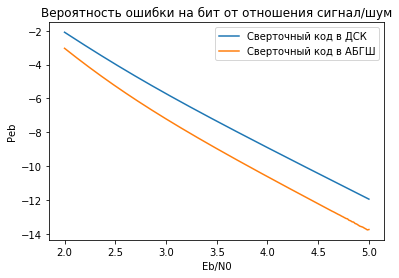

In [617]:
compare_methods()

# Задание 7

Коэффициенты были найдены в предыдущем задании поэтому просто построим графики для усеченного варианта полинома F.

In [618]:
f[14] = 0
f[16] = 0
f[18] = 0
f[20] = 0

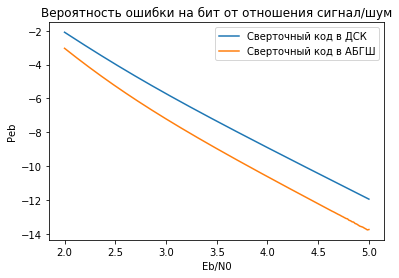

In [619]:
compare_methods()

Графики практически не различаются => Усечение дает хорошее приближение